In [1]:
import emcee
import numpy as np 
import corner as DFM
# --- emanu---
from emanu import compressor as Comp

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
theta_true = np.array([0.5, 0.5])
cov_true = np.identity(20)
def model(theta): 
    return theta[0] * np.arange(20) + theta[1]
X_true = model(theta_true)

In [4]:
X_data = np.random.multivariate_normal(model(theta_true), cov_true, size=1000)
cov_data = np.cov(X_data.T)

cinv_data = np.linalg.inv(cov_data)

nmock, ndata = X_data.shape
print float(nmock - ndata - 2)/float(nmock - 1) 
cinv_data *= float(nmock - ndata - 2)/float(nmock - 1) 

0.978978978979


(0.0, 19.0)

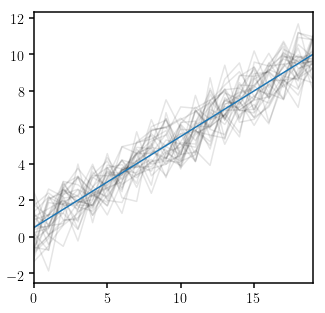

In [5]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
for _x in X_data[:30]: 
    sub.plot(_x, c='k', alpha=0.1)
sub.plot(model(theta_true))
sub.set_xlim(0., 19.)

In [11]:
theta_0m = np.array([theta_true[0]-0.1, theta_true[1]])
theta_0p = np.array([theta_true[0]+0.1, theta_true[1]])
theta_1m = np.array([theta_true[0], theta_true[1]-0.1])
theta_1p = np.array([theta_true[0], theta_true[1]+0.1])
dXd0 = (model(theta_0p) - model(theta_0m))/0.2
dXd1 = (model(theta_1p) - model(theta_1m))/0.2
dXdtheta = np.array([dXd0, dXd1])

In [13]:
cmpsr = Comp.Compressor(method='KL')      
cmpsr.fit(X_data, dXdtheta)

In [14]:
cX_true = cmpsr.transform(np.atleast_2d(model(theta_true)))

cX_data = cmpsr.transform(X_data)

ccov_data = np.cov(cX_data.T)

ccinv_data = np.linalg.inv(ccov_data) * float(cX_data.shape[0] - cX_data.shape[1] - 2)/float(cX_data.shape[0] - 1) 

(0.0, 1)

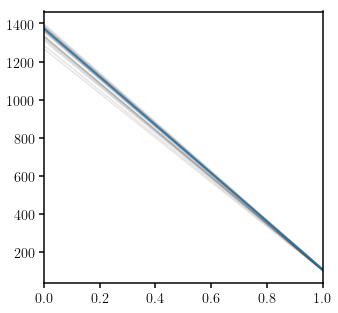

In [15]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
for _cx in cX_data[:20]: 
    sub.plot(_cx, c='k', alpha=0.1)
sub.plot(cX_true.flatten(), c='C0')
sub.set_xlim(0., cX_data.shape[1]-1)

In [16]:
# initialize walkers randomly drawn from prior 
ndim = len(theta_true)

prior_range = np.array([[0.25, 0.75], [-0.5, 1.5]])

def lnprior(tt): 
    ''' log uniform prior. totally uninformative
    '''
    t0, t1 = tt 
    if (prior_range[0][0] <= t0 <= prior_range[0][1]) and (prior_range[1][0] <= t1 <= prior_range[1][1]):
        return 0.0 
    return -np.inf 

In [17]:
def lnlike(tt): 
    ''' log likelihood of the full data
    '''
    delta = (model(tt) - X_true) 
    return -0.5*np.dot(delta, np.dot(cinv_data, delta.T))

def lnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + lnlike(tt)

In [18]:
def mcmc(lnpost, nwalkers=100, burn_in_chain=200, main_chain=1000): 
    pos = [np.random.uniform(prior_range[:,0], prior_range[:,1]) for i in range(nwalkers)]

    # run mcmc 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)

    print('running burn-in chain') 
    pos, prob, state = sampler.run_mcmc(pos, burn_in_chain)
    sampler.reset()
    print('running main chain') 
    sampler.run_mcmc(pos, main_chain)

    # save chain 
    post = sampler.flatchain.copy() 
    return post

running burn-in chain
running main chain


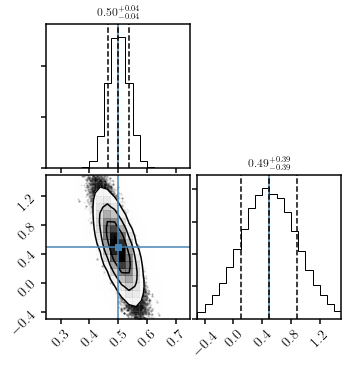

In [19]:
# save chain 
post = mcmc(lnprob)

fig = DFM.corner(post, color='k', quantiles=[0.16, 0.5, 0.84], bins=20, range=prior_range, truths=theta_true,
        smooth=True, show_titles=True, label_kwargs={'fontsize': 20}) 

In [20]:
def clnlike(tt): 
    ''' log likelihood of the compressed data
    '''
    cmodel = cmpsr.transform(np.atleast_2d(model(tt)))
    delta = (cmodel.flatten() - cX_true.flatten()) 
    return -0.5*np.dot(delta, np.dot(ccinv_data, delta.T))

def clnprob(tt):
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + clnlike(tt)

In [21]:
cpost = mcmc(clnprob)

running burn-in chain
running main chain


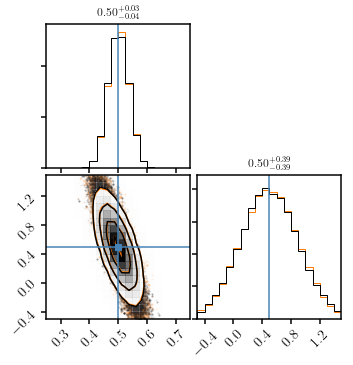

In [23]:
fig = DFM.corner(cpost, color='C1', bins=20, range=prior_range, truths=theta_true,
        smooth=True, show_titles=True, label_kwargs={'fontsize': 20}) 
fig = DFM.corner(post, color='k', bins=20, range=prior_range, smooth=True, fig=fig)